In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
orders=pd.read_csv("orders_all_join_tab.csv",keep_default_na=False,na_filter=True)
datanew=pd.read_csv("device_repeat_tab.csv",keep_default_na=False,na_filter=True)

# Feature Engineering

Get account and device information

In [3]:
result=pd.merge(orders,datanew,left_on="device_id",right_on="device_id",how="inner")

Calculate the registration time of the order account and the time of this order

In [4]:
result['ordermins'] = pd.to_datetime(result['order_date'])
result['joinmins'] =  pd.to_datetime(result['join_date'])
result['RegisteredTime']=(result['ordermins']-result['joinmins']).dt.seconds

Calculate the length of user ID number

In [5]:
result["len"]=result["certificate"].str.len()

# Label

In [6]:
target = result['flag'].values

# Data

In [7]:
data_pre=result[['browsing_time','refund_rate','RegisteredTime','count','repeat','len']].values
showresult=result[['browsing_time','refund_rate','RegisteredTime','count','repeat','len']]

# Data visualization

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


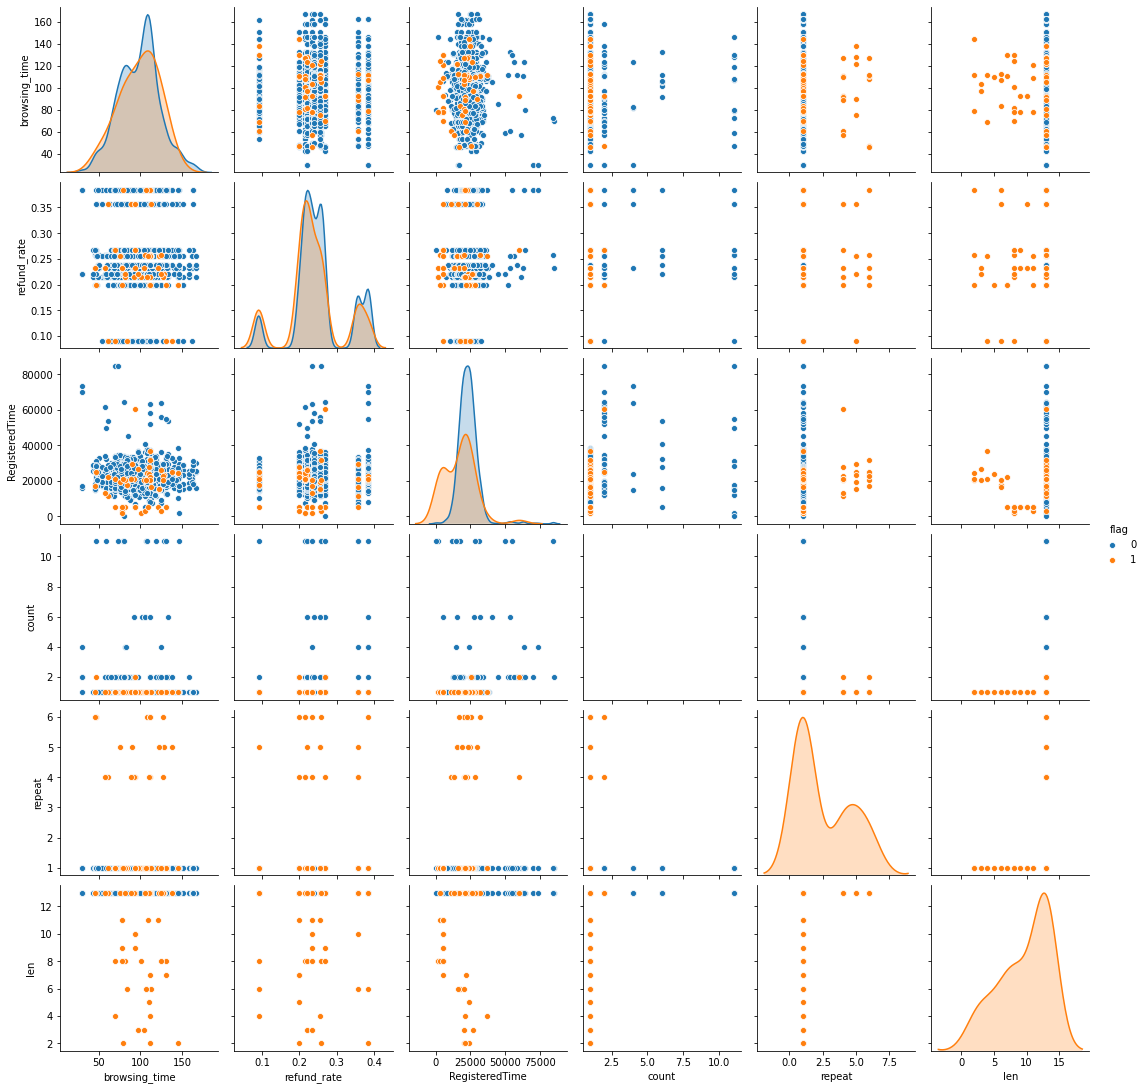

In [8]:
import seaborn as sns

feature=result[['browsing_time','refund_rate','RegisteredTime','count','repeat','len','flag']]
sns.pairplot(feature, hue='flag')
plt.show()

# Prepare Training sets And Test Datasets

Cross validation：https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [9]:
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    data_pre, target, test_size=0.3, random_state=42,shuffle=True
)

# Choose Decision Tree

In [10]:
from sklearn import tree
from sklearn import metrics

dtc=tree.DecisionTreeClassifier()
dtc.fit(X_train,y_train)   #使用训练集进行训练

DecisionTreeClassifier()

# Model Evaluation

In [11]:
print(dtc.score(X_train,y_train))
print(dtc.score(X_test,y_test))
y_predict=dtc.predict(X_test)

1.0
0.9821428571428571


# Confusion matrix

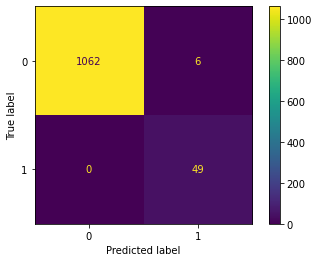

In [12]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y_pred = dtc.predict(data_pre)
y_true=target
cm=confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtc.classes_)
disp.plot()

# Metrics

In [13]:
from sklearn import metrics 
print('Accuracy:',metrics.accuracy_score(y_test,y_predict))
print('Precision:',metrics.precision_score(y_test,y_predict,average='macro'))
print('Recall:',metrics.recall_score(y_test,y_predict,average='macro'))
print('F1-score:',metrics.f1_score(y_test,y_predict,average='macro',zero_division=1))

Accuracy: 0.9821428571428571
Precision: 0.8695652173913043
Recall: 0.9905956112852665
F1-score: 0.920253164556962


Model Evaluation：https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation

# Decision Tree visualization

In [14]:
import pydotplus
with open("tree6.pdf", 'w') as doc_data: dot_data = tree.export_graphviz(dtc, out_file=None,
                         feature_names=['browsing_time','refund_rate','RegisteredTime','count','repeat','len'],
                         class_names=['0', '1'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_pdf("tree.pdf")

True

Pre-pruning

In [15]:
dtc_pruning=tree.DecisionTreeClassifier(max_depth=4,random_state=10)
dtc_pruning.fit(X_train,y_train)  

with open("pruning_tree.pdf", 'w') as doc_data: dot_data = tree.export_graphviz(dtc_pruning, out_file=None,
                         feature_names=['browsing_time','refund_rate','RegisteredTime','count','repeat','len'],
                         class_names=['0', '1'],
                         filled=True, rounded=True,
                         special_characters=True)
graph_pruning = pydotplus.graph_from_dot_data(dot_data)

graph_pruning.write_pdf("pruning_tree.pdf")

True

# Show Feature Importance

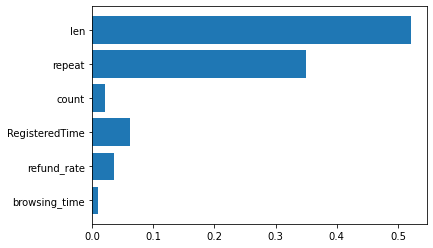

In [16]:
plt.barh(range(6), dtc.feature_importances_, align='center', tick_label=['browsing_time','refund_rate','RegisteredTime','count','repeat','len'])
plt.show()

# Try other model

# RandomForest , GradientBoostring  and Cross-Validation  

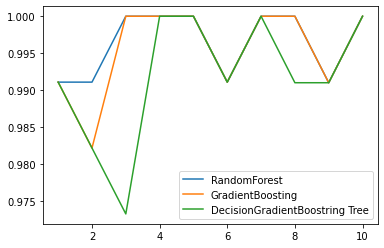

In [17]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

rfc=RandomForestClassifier(n_estimators=6)
gbc=GradientBoostingClassifier(random_state=42)

rfcscores=cross_val_score(rfc,data_pre,target,cv=10)
gbcscores=cross_val_score(gbc,data_pre,target,cv=10)
dtcscores=cross_val_score(dtc,data_pre,target,cv=10)

plt.plot(range(1,11),rfcscores,label = "RandomForest")
plt.plot(range(1,11),gbcscores,label = "GradientBoosting")
plt.plot(range(1,11),dtcscores,label = "DecisionGradientBoostring Tree")
plt.legend()
plt.show()

# Try 10 times

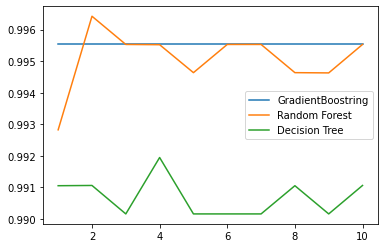

In [18]:
rfc_l = []
dtc_l = []
gbc_l=[]

for i in range(10):
    gbc_s = cross_val_score(gbc,data_pre,target,cv=10).mean()
    gbc_l.append(gbc_s)
    
    rfc_s = cross_val_score(rfc,data_pre,target,cv=10).mean()
    rfc_l.append(rfc_s)
    
    dtc_s = cross_val_score(dtc,data_pre,target,cv=10).mean()
    dtc_l.append(dtc_s)

plt.plot(range(1,11),gbc_l,label = "GradientBoostring")
plt.plot(range(1,11),rfc_l,label = "Random Forest")
plt.plot(range(1,11),dtc_l,label = "Decision Tree")
plt.legend()
plt.show()